In [18]:
### CALCULATE ALLELE FREQUENCIES ############
#Import necessary libraries
import pandas as pd
import numpy as np
# Load mutation data obtained after variant calling without filters
df_mutations = pd.read_csv('/home/vant/TFM/Filtered_TOVC_OVAseq_all.txt', sep='\t')
print(df_mutations.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40093 entries, 0 to 40092
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Sample                     40093 non-null  object 
 1   InfoTakenFrom              40093 non-null  object 
 2   MutRecurrence              40093 non-null  int64  
 3   Pos                        40093 non-null  object 
 4   Ref                        40093 non-null  object 
 5   Alt                        40093 non-null  object 
 6   Gene                       40093 non-null  object 
 7   Census                     30065 non-null  object 
 8   RefReads                   40093 non-null  int64  
 9   AltReads                   40093 non-null  int64  
 10  TotalDepth                 40093 non-null  int64  
 11  AlleleFrequency            40093 non-null  float64
 12  Function                   40093 non-null  object 
 13  Consequence                30531 non-null  obj

In [19]:
print(df_mutations.head())

   Sample      InfoTakenFrom  MutRecurrence            Pos Ref Alt    Gene  \
0  16T131  2:MuTect2+VarDict              3  chr1:11272978   G   A    MTOR   
1  16T131  2:MuTect2+VarDict              1  chr1:11303354   G   A    MTOR   
2  16T131  2:MuTect2+VarDict              1  chr1:14107473   C   T   PRDM2   
3  16T131  2:MuTect2+VarDict              1  chr1:14107490   C   T   PRDM2   
4  16T131  2:MuTect2+VarDict              1  chr1:27023207   G   A  ARID1A   

        Census  RefReads  AltReads  ...  Pseudogene  ValOncMut DOCM Cosmic95  \
0     oncogene       159         5  ...         NaN        NaN  NaN        0   
1     oncogene       237         6  ...         NaN        NaN  NaN        0   
2          TSG       291         7  ...         NaN        NaN  NaN        0   
3          TSG       330         5  ...         NaN        NaN  NaN        0   
4  TSG, fusion       139         4  ...         NaN        NaN  NaN        0   

  MSKCC OncoKB  ClinvarSignificance  ClinvarReview

In [20]:
# Remove specific samples with artefacts and mixed case (RVB3)
df_mutations = df_mutations[~df_mutations['Sample'].isin(['OVE44', 'OVE16','RVB3'])]

# Rename specific samples in df_mutations
df_mutations.loc[:,'Sample'] = df_mutations['Sample'].replace({
    'LP16_old': 'LP16', 
    'LP17_old': 'LP17', 
    'MDA51T1': 'MDA51_T1_CCC', 
    'MDA51T2': 'MDA51_T2_EC'
})

# Load file containing other variables
df_variables = pd.read_excel('/home/vant/TFM/Final_db/Samples_alltypedata_annotated.xlsx')

# Remove the first two rows from df_variables
df_variables = df_variables.iloc[2:].reset_index(drop=True)

########Firstly we change misclassified samples to redo the analysis  #######################
# Change the values to 'MMRp' for samples 'LP20', 'LP26', and 'MDA15'
# We use .loc[] to access specific rows where 'ID_CNIO' matches one of the specified samples
df_variables.loc[df_variables['ID_CNIO'].isin(['LP20', 'LP26', 'MDA15']), 'MMR_final_status'] = 'MMRp'

# Change the values to 'MMRd' for sample 'MDA26'
df_variables.loc[df_variables['ID_CNIO'].isin(['MDA26']), 'MMR_final_status'] = 'MMRd'

# Remove samples with artefacts in variant calling and mixed case (RVB3)
df_variables = df_variables[~df_variables['ID_CNIO'].isin(['OVE44', 'OVE16','RVB3'])]

# Select necessary columns and make an independent copy
columns_of_interest = ['ID_CNIO','HISTOLOGY','MMR_final_status']
df_variables_filtered = df_variables[columns_of_interest].copy()

# Clean values for merging in the independent copy
df_variables_filtered['ID_CNIO'] = df_variables_filtered['ID_CNIO'].str.strip().str.upper()

# Clean values in df_mutations
df_mutations['Sample'] = df_mutations['Sample'].str.strip().str.upper()

# Merge DataFrames based on common columns. I keep only samples in both dataframes
df_combined = pd.merge(df_mutations, df_variables_filtered, left_on='Sample', right_on='ID_CNIO', how='inner')

# Print the length of the combined DataFrame
print("Length of df_combined is:", len(df_combined))

# Check the resulting merged DataFrame
print(df_combined.head())
print(df_combined.isnull().sum())  # Check for any missing values

# Keep useful columns in a new dataframe
mutations_subset = df_combined[['Sample', 'Gene','Function', 'Abbreviation', 'Ref', 'Alt', 'AlleleFrequency','TotalDepth', 'Varsome','HISTOLOGY','MMR_final_status']]
# Show first rows
print(mutations_subset.head())

Length of df_combined is: 35107
  Sample      InfoTakenFrom  MutRecurrence            Pos Ref Alt  Gene  \
0    LP1  2:MuTect2+VarDict              1  chr1:11181356   T   C  MTOR   
1    LP1  2:MuTect2+VarDict              1  chr1:11186849   G   A  MTOR   
2    LP1  2:MuTect2+VarDict              1  chr1:11188056   C   T  MTOR   
3    LP1  2:MuTect2+VarDict              2  chr1:11189011   G   A  MTOR   
4    LP1  2:MuTect2+VarDict              1  chr1:11199609   C   T  MTOR   

     Census  RefReads  AltReads  ...  Cosmic95  MSKCC OncoKB  \
0  oncogene       322         5  ...         1      1    NaN   
1  oncogene       157         4  ...         0      0    NaN   
2  oncogene       123         4  ...         0      0    NaN   
3  oncogene       103         3  ...         0      0    NaN   
4  oncogene       103         3  ...         0      0    NaN   

  ClinvarSignificance ClinvarReviewStatus  \
0                 NaN                 NaN   
1                 NaN                 NaN 

In [21]:
######## DEDUCE VARIANT TYPE ##############

# Remove duplicate variants (same combination of sample-gene-variant) and keep the first occurrence
df_combined_unique = df_combined.drop_duplicates(subset=['Sample', 'Gene', 'Varsome'], keep='first')

# Verify the first few rows of the DataFrame without duplicates
print(df_combined_unique.head())

# Ensure that it's not a view but a copy to avoid SettingWithCopyWarning
df_combined_unique = df_combined_unique.copy()

# Initialize the 'Variant_Type' column as an 'object' type column with NaN values directly using loc
df_combined_unique.loc[:, 'Variant_Type'] = np.nan
df_combined_unique.loc[:, 'Variant_Type'] = df_combined_unique['Variant_Type'].astype(object)

# Assign 'SNP' for single nucleotide substitutions (Single Nucleotide Polymorphisms)
df_combined_unique.loc[(df_combined_unique['Ref'] != df_combined_unique['Alt']) &
                       (df_combined_unique['Ref'].str.len() == 1) &
                       (df_combined_unique['Alt'].str.len() == 1), 'Variant_Type'] = 'SNP'

# Assign 'INS' for insertions
df_combined_unique.loc[df_combined_unique['Alt'].str.len() > df_combined_unique['Ref'].str.len(), 'Variant_Type'] = 'INS'

# Assign 'DEL' for deletions
df_combined_unique.loc[df_combined_unique['Ref'].str.len() > df_combined_unique['Alt'].str.len(), 'Variant_Type'] = 'DEL'

# Verify the unique values in the 'Variant_Type' column
print(df_combined_unique['Variant_Type'].unique())

  Sample      InfoTakenFrom  MutRecurrence            Pos Ref Alt  Gene  \
0    LP1  2:MuTect2+VarDict              1  chr1:11181356   T   C  MTOR   
1    LP1  2:MuTect2+VarDict              1  chr1:11186849   G   A  MTOR   
2    LP1  2:MuTect2+VarDict              1  chr1:11188056   C   T  MTOR   
3    LP1  2:MuTect2+VarDict              2  chr1:11189011   G   A  MTOR   
4    LP1  2:MuTect2+VarDict              1  chr1:11199609   C   T  MTOR   

     Census  RefReads  AltReads  ...  Cosmic95  MSKCC OncoKB  \
0  oncogene       322         5  ...         1      1    NaN   
1  oncogene       157         4  ...         0      0    NaN   
2  oncogene       123         4  ...         0      0    NaN   
3  oncogene       103         3  ...         0      0    NaN   
4  oncogene       103         3  ...         0      0    NaN   

  ClinvarSignificance ClinvarReviewStatus  \
0                 NaN                 NaN   
1                 NaN                 NaN   
2                 NaN        

In [22]:
# Get the frequency count of each class in the 'Variant_Type' column
variant_type_frequencies = df_combined_unique['Variant_Type'].value_counts()
# Display the frequency counts
print(variant_type_frequencies)
# Get the relative frequencies (proportions) of each class in 'Variant_Type'
variant_type_frequencies_relative = df_combined_unique['Variant_Type'].value_counts(normalize=True)
# Display the relative frequencies (proportions)
print(variant_type_frequencies_relative)

Variant_Type
SNP    33515
DEL      800
INS      256
Name: count, dtype: int64
Variant_Type
SNP    0.969454
DEL    0.023141
INS    0.007405
Name: proportion, dtype: float64


In [23]:
# Create a new column 'Mutation' with the format Ref>Alt (Reference>Alteration)
df_combined_unique['Mutation'] = df_combined_unique['Ref'] + '>' + df_combined_unique['Alt']
# Display the first 40 rows to verify the result
print(df_combined_unique[['Ref', 'Alt', 'Mutation']].head(40))

   Ref Alt Mutation
0    T   C      T>C
1    G   A      G>A
2    C   T      C>T
3    G   A      G>A
4    C   T      C>T
5    C   T      C>T
6    G   A      G>A
7    C   T      C>T
8    C   T      C>T
9    C   T      C>T
10   C   T      C>T
11   G   T      G>T
12   G   A      G>A
13   G   A      G>A
14   G   A      G>A
15   G   A      G>A
16   C   T      C>T
17   G   A      G>A
18   C   T      C>T
19   C   T      C>T
20   G   A      G>A
21   G   A      G>A
22   C   T      C>T
23   C   T      C>T
24   G   A      G>A
25   C   T      C>T
26   G   T      G>T
27   C   T      C>T
28   G   A      G>A
29   G   A      G>A
30   C   T      C>T
31   G   A      G>A
32   C   T      C>T
33   C   T      C>T
34   G   A      G>A
35   G   A      G>A
36   C   T      C>T
37   G   A      G>A
38   C   T      C>T
39   C   T      C>T


In [24]:
# Calculate the percentage of each type of mutation 
mutation_percentages = df_combined_unique['Mutation'].value_counts(normalize=True) * 100
# Show the results
print(mutation_percentages)

Mutation
C>T                        46.958283
G>A                        38.891742
A>G                         2.097244
T>C                         2.003082
G>T                         1.286880
                             ...    
TATGGCCCTAAC>T              0.002853
ATAACT>A                    0.002853
GATTA>G                     0.002853
GCCTCCTGCTTGTTGCCTCAT>G     0.002853
TCTC>T                      0.002853
Name: proportion, Length: 408, dtype: float64


In [25]:
# Count the frequencies of each type of mutation
change_counts = df_combined_unique['Mutation'].value_counts()
# Filter only the SNPs (changes of length 3: X>X)
snp_changes = df_combined_unique[df_combined_unique['Mutation'].str.len() == 3]
# Count the frequencies of each type of SNP change
change_counts = snp_changes['Mutation'].value_counts()
# Calculate the percentage of each type of change
total_snp_changes = change_counts.sum()  # Sum all the counts of SNP changes
change_percentage = (change_counts / total_snp_changes) * 100  # Calculate the percentage of each SNP change out of the total
# Print the results
print("Percentage of each SNP change out of the total SNPs:")
print(change_percentage)

Percentage of each SNP change out of the total SNPs:
Mutation
C>T    49.103387
G>A    40.668357
A>G     2.193048
T>C     2.094585
G>T     1.345666
C>A     1.256154
C>G     0.692227
A>C     0.593764
T>G     0.593764
A>T     0.554975
T>A     0.495301
G>C     0.408772
Name: count, dtype: float64


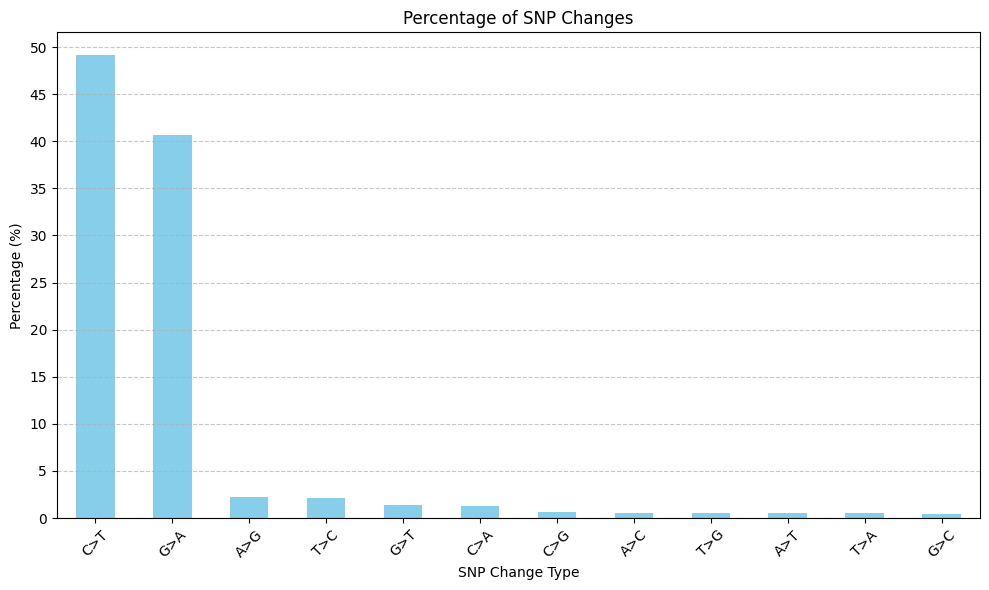

In [26]:
###### HISTOGRAM WITH PERCENTAGES OF SNPs TYPES ###############

# Import necessary libraries to plot results
import matplotlib.pyplot as plt  # Library for creating visualizations and plots
# Plot the percentages as a histogram (bar plot)
plt.figure(figsize=(10, 6))  # Set the size of the figure (width 10 inches, height 6 inches)
change_percentage.plot(kind='bar', color='skyblue')  # Create a bar plot with skyblue color for the bars

# Configure the title and labels
plt.title('Percentage of SNP Changes')  # Title of the plot
plt.xlabel('SNP Change Type')  # Label for the x-axis
plt.ylabel('Percentage (%)')  # Label for the y-axis
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees for better readability

# Set y-axis ticks every 5 units
plt.yticks(range(0, int(change_percentage.max()) + 5, 5))  # Adjust the y-ticks based on the maximum percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines along the y-axis with a dashed line style and 70% opacity

# Save the plot as a PNG file
plt.savefig('/home/vant/TFM/Plots_TFM_final/SNP_changes_percentage.png', format='png', dpi=300, bbox_inches='tight')  # Save with high resolution (300 dpi)

# Display the plot
plt.tight_layout()  # Adjust layout to ensure nothing is cut off
plt.show()  # Show the plot in the output

In [27]:
####  FFPE artifacts are typically C>T or A>G changes at low frequency so we study the allele frequencies
#### of these changes in our cohort to decide what filter use ############################################

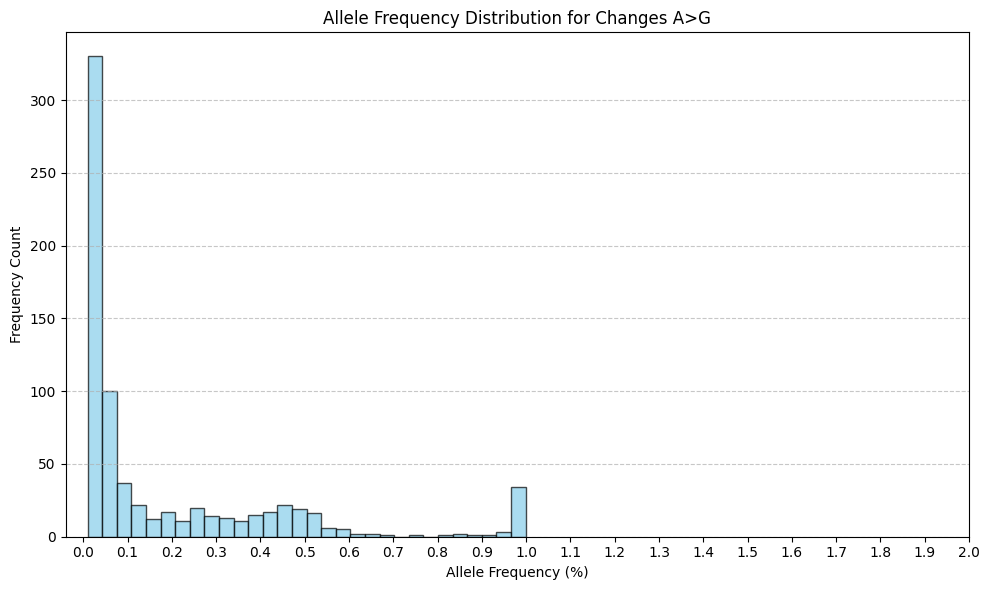

In [28]:
###### HISTOGRAM WITH ALLELE FREQUENCIES FOR CHANGES A>G ###############
# Filter the mutations of interest (specifically 'A>G' changes)
changes_of_interest = df_combined_unique[df_combined_unique['Mutation'].isin(['A>G'])]

# Create a histogram of allele frequency distribution
plt.figure(figsize=(10, 6))  # Set the figure size (10 inches wide, 6 inches tall)
plt.hist(changes_of_interest['AlleleFrequency'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Plot histogram with 30 bins, skyblue color, black edges, and 70% opacity

# Configure the title and labels
plt.title('Allele Frequency Distribution for Changes A>G')  # Set the plot title
plt.xlabel('Allele Frequency (%)')  # Set the x-axis label (allele frequency in percentage)
plt.ylabel('Frequency Count')  # Set the y-axis label (frequency count of each allele frequency bin)
plt.xticks([i / 10 for i in range(0, 21)])  # Set the x-axis ticks from 0% to 20% (in increments of 0.1)

# Display the grid on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines along the y-axis with dashed lines and 70% opacity

# Adjust layout to prevent clipping and show the plot
plt.tight_layout()  # Adjust the layout of the plot to ensure nothing is cut off
plt.show()  # Display the plot


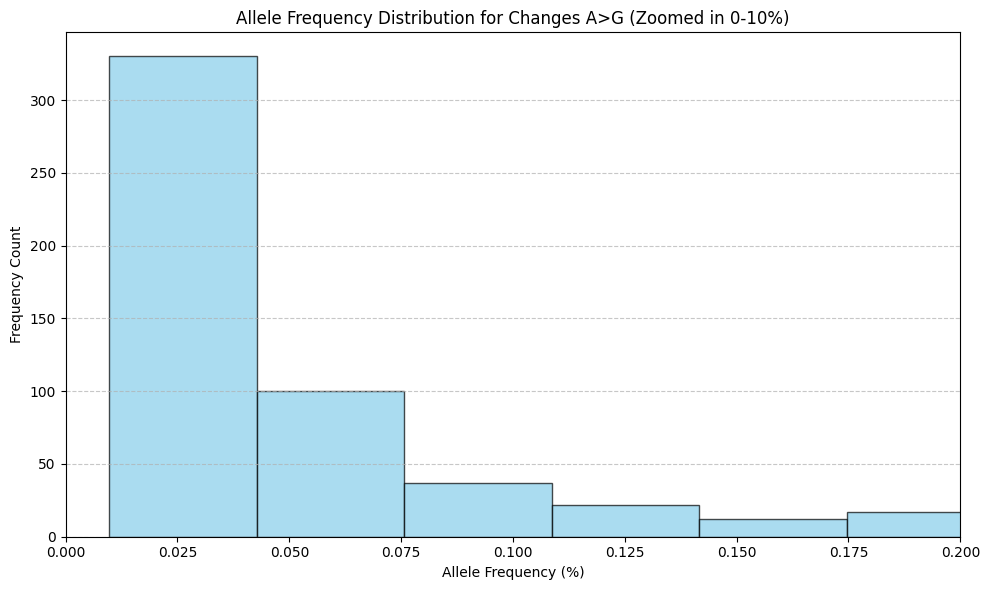

In [29]:
# Filter the mutations of interest (specifically 'A>G' changes)
changes_of_interest = df_combined_unique[df_combined_unique['Mutation'].isin(['A>G'])]

# Create a histogram of allele frequency distribution
plt.figure(figsize=(10, 6))  # Set the figure size (10 inches wide, 6 inches tall)
plt.hist(changes_of_interest['AlleleFrequency'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Plot histogram with 30 bins, skyblue color, black edges, and 70% opacity

# Configure the title and labels
plt.title('Allele Frequency Distribution for Changes A>G (Zoomed in 0-10%)')  # Set the plot title
plt.xlabel('Allele Frequency (%)')  # Set the x-axis label (allele frequency in percentage)
plt.ylabel('Frequency Count')  # Set the y-axis label (frequency count of each allele frequency bin)

# Limit the x-axis between 0 and 0.1 to zoom in on this region
plt.xlim(0, 0.2)  # Set the x-axis limit from 0% to 10% allele frequency

# Display the grid on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines along the y-axis with dashed lines and 70% opacity

# Adjust layout to prevent clipping and show the plot
plt.tight_layout()  # Adjust the layout of the plot to ensure nothing is cut off
plt.show()  # Display the plot


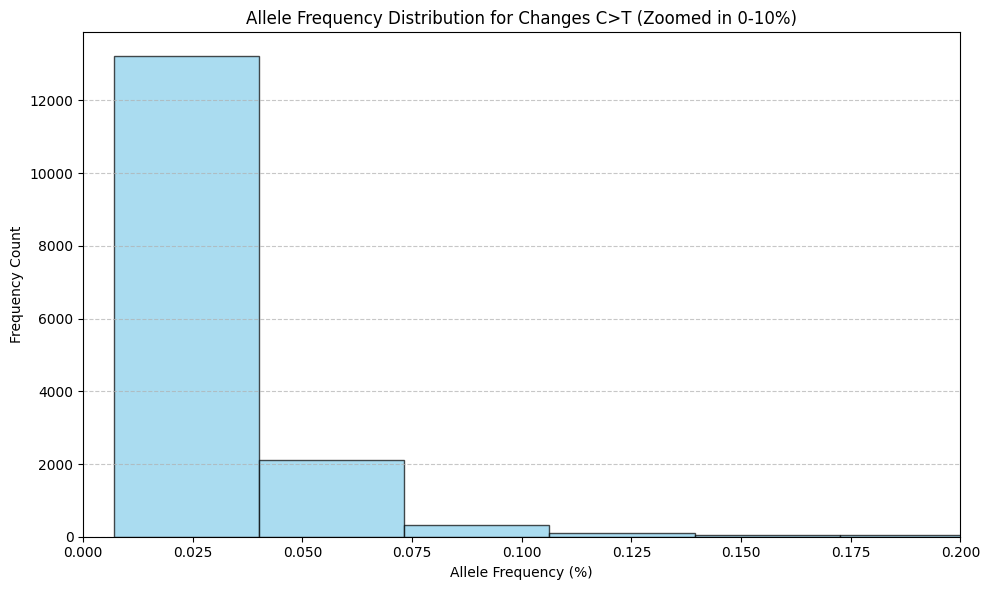

In [30]:
# Filter the mutations of interest (specifically 'C>T' changes)
changes_of_interest = df_combined_unique[df_combined_unique['Mutation'].isin(['C>T'])]

# Create a histogram of allele frequency distribution
plt.figure(figsize=(10, 6))  # Set the figure size (10 inches wide, 6 inches tall)
plt.hist(changes_of_interest['AlleleFrequency'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Plot histogram with 30 bins, skyblue color, black edges, and 70% opacity

# Configure the title and labels
plt.title('Allele Frequency Distribution for Changes C>T (Zoomed in 0-10%)')  # Set the plot title
plt.xlabel('Allele Frequency (%)')  # Set the x-axis label (allele frequency in percentage)
plt.ylabel('Frequency Count')  # Set the y-axis label (frequency count of each allele frequency bin)

# Limit the x-axis between 0 and 0.1 to zoom in on this region
plt.xlim(0, 0.2)  # Set the x-axis limit from 0% to 20% allele frequency

# Display the grid on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines along the y-axis with dashed lines and 70% opacity

# Adjust layout to prevent clipping and show the plot
plt.tight_layout()  # Adjust the layout of the plot to ensure nothing is cut off
plt.show()  # Display the plot


In [31]:
### After seeing the results, I decide to use VAF>0.1, so this is the threshold used to obtain driver mutations. #########
### This filtering is performed in R using adapted code from a CNIO member of the group and allow us to obtain the filtered mutation
### file with driver mutations that we load now ############################################################################
# Load filterd file with driver mutations (VAF>0.1)
df_mutations = pd.read_excel('/home/vant/TFM/High_Filter_Davidaltreads40VAF0.1.xlsx')

# Remove specific samples with artefacts and mixed case (RVB3)
df_mutations = df_mutations[~df_mutations['Sample'].isin(['OVE44', 'OVE16','RVB3'])]

# Rename specific samples in df_mutations
df_mutations.loc[:,'Sample'] = df_mutations['Sample'].replace({
    'LP16_old': 'LP16', 
    'LP17_old': 'LP17', 
    'MDA51T1': 'MDA51_T1_CCC', 
    'MDA51T2': 'MDA51_T2_EC'
})

# Load file containing other variables
df_variables = pd.read_excel('/home/vant/TFM/Final_db/Samples_alltypedata_annotated.xlsx')

# Remove the first two rows from df_variables
df_variables = df_variables.iloc[2:].reset_index(drop=True)

########Firstly we change misclassified samples to redo the analysis  #######################
# Change the values to 'MMRp' for samples 'LP20', 'LP26', and 'MDA15'
# We use .loc[] to access specific rows where 'ID_CNIO' matches one of the specified samples
df_variables.loc[df_variables['ID_CNIO'].isin(['LP20', 'LP26', 'MDA15']), 'MMR_final_status'] = 'MMRp'

# Change the values to 'MMRd' for sample 'MDA26'
df_variables.loc[df_variables['ID_CNIO'].isin(['MDA26']), 'MMR_final_status'] = 'MMRd'

# Remove samples with artefacts in variant calling and mixed case (RVB3)
df_variables = df_variables[~df_variables['ID_CNIO'].isin(['OVE44', 'OVE16','RVB3'])]

# Select necessary columns and make an independent copy
columns_of_interest = ['ID_CNIO','HISTOLOGY','MMR_final_status']
df_variables_filtered = df_variables[columns_of_interest].copy()

# Clean values for merging in the independent copy
df_variables_filtered['ID_CNIO'] = df_variables_filtered['ID_CNIO'].str.strip().str.upper()

# Clean values in df_mutations
df_mutations['Sample'] = df_mutations['Sample'].str.strip().str.upper()

# Merge DataFrames based on common columns. I keep only samples in both dataframes
df_combined = pd.merge(df_mutations, df_variables_filtered, left_on='Sample', right_on='ID_CNIO', how='inner')

# Print the length of the combined DataFrame
print("Length of df_combined is:", len(df_combined))

# Remove duplicate variants (same combination of sample-gene-variant) and keep the first occurrence
df_combined_unique = df_combined.drop_duplicates(subset=['Sample', 'Gene', 'Varsome'], keep='first')

# Verify the first few rows of the DataFrame without duplicates
print(df_combined_unique.head())

# Ensure that it's not a view but a copy to avoid SettingWithCopyWarning
df_combined_unique = df_combined_unique.copy()

Length of df_combined is: 583
  Sample                InfoTakenFrom  MutRecurrence             Pos Ref Alt  \
0    LP1  3:MuTect2+VarDict+FreeBayes              1   chr1:27100324   C   T   
1    LP1  3:MuTect2+VarDict+FreeBayes              5   chr3:41266101   C   G   
2    LP1  3:MuTect2+VarDict+FreeBayes              2  chr10:89624275   C   T   
3   LP13  3:MuTect2+VarDict+FreeBayes              1   chr1:27106829   T   A   
4   LP13  3:MuTect2+VarDict+FreeBayes              1   chr5:67590474  TA   T   

     Gene            Census  RefReads  AltReads  ...  Cosmic95  MSKCC  \
0  ARID1A       TSG, fusion       564       111  ...         2      1   
1  CTNNB1  oncogene, fusion       203        46  ...       299     32   
2    PTEN               TSG       354        89  ...        30      7   
3  ARID1A       TSG, fusion       511       331  ...         1      0   
4  PIK3R1               TSG       445       151  ...         0      0   

                        OncoKB       ClinvarSignif

In [32]:
# Filter the rows with variants where 'MMR_final_status' is 'MMRd'
df_mmrd = df_combined_unique[df_combined_unique['MMR_final_status'] == 'MMRd']

# Check the length of the filtered DataFrame
print("Length of df_mmrd is:", len(df_mmrd))

# Check the first few rows of the filtered DataFrame
print(df_mmrd.head())

Length of df_mmrd is: 179
   Sample                InfoTakenFrom  MutRecurrence             Pos Ref Alt  \
7    LP16  3:MuTect2+VarDict+FreeBayes              1   chr1:27099102  TC   T   
8    LP16  3:MuTect2+VarDict+FreeBayes              1   chr17:7578406   C   T   
9    LP16  3:MuTect2+VarDict+FreeBayes              1   chr17:7578458   G   A   
10   LP16            2:MuTect2+VarDict              4  chr17:48433966  AC   A   
11   LP16            2:MuTect2+VarDict              2  chr18:57013193  CT   C   

      Gene                 Census  RefReads  AltReads  ...  Cosmic95  MSKCC  \
7   ARID1A            TSG, fusion       655       102  ...         8      3   
8     TP53  oncogene, TSG, fusion       418        75  ...      1990    386   
9     TP53  oncogene, TSG, fusion       569       108  ...        31      5   
10   XYLT2                    NaN       844       101  ...        97     41   
11   LMAN1                    NaN       168        54  ...        52     17   

            

In [35]:
# Filter mutations in genes of interest (involved in MMR and POLE/POLD1)
genes_group_1 = ['MSH6', 'MSH2', 'MLH1', 'PMS2']
genes_group_2 = ['POLE', 'POLD1']

df_mmrdpole_samples = df_mmrd_genes[df_mmrd_genes['Gene'].isin(genes_group_1 + genes_group_2)]

# Check length
print("Length of df_selected_samples is:", len(df_mmrdpole_samples))

# Show the results
print(df_mmrdpole_samples[['ID_CNIO','Gene','AlleleFrequency']])

Length of df_selected_samples is: 19
    ID_CNIO   Gene  AlleleFrequency
13     LP16   MSH2           0.1064
17     LP17   MSH6           0.4621
18     LP17   MSH6           0.2993
53     LP21   PMS2           0.8029
61     LP22   PMS2           0.3333
86     LP30   MLH1           0.5584
150   OVE64   MSH6           0.3470
155   OVE64  POLD1           0.2163
171   OVE86   MSH6           0.3188
178   OVE86  POLD1           0.3220
349   MDA16   MSH6           0.4225
350   MDA16   MSH6           0.3606
370   MDA16   POLE           0.4347
398   MDA26   MSH2           0.3537
472   MDA47   MLH1           0.8065
501    MDA9   MSH2           0.1190
557    RVB2   MLH1           0.7688
567    RVB2  POLD1           0.3675
571    RVB5   MLH1           0.6960
